In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import diffusion_dist as diff

import matplotlib.pyplot as plt

from sklearn import decomposition, preprocessing
from torch.utils.data import Dataset, DataLoader

import model.autoencoder as ae

from dataset import *

from utils import *
from model.loss import *
import phate
import umap 
from sklearn.manifold import TSNE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
rna_dataset = symsim2_rna(counts_dir = "./data/symsim2/rand1/GxC1.txt", anno_dir = "./data/symsim2/rand1/cell_label1.txt")
atac_dataset = symsim2_atac(counts_dir = "./data/symsim2/rand1/RxC2.txt", anno_dir = "./data/symsim2/rand1/cell_label2.txt")

In [3]:
rna_CONFIG = { 
    'in_features': 1000,
    'layers': [512, 128, 8], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

atac_CONFIG = { 
    'in_features': 3000,
    'layers': [512, 128, 8], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

train_rna_loader = DataLoader(rna_dataset, batch_size = rna_CONFIG["minibatch_size"], shuffle = True)
train_atac_loader = DataLoader(atac_dataset, batch_size = atac_CONFIG["minibatch_size"], shuffle = True)
test_rna_loader = DataLoader(rna_dataset, batch_size = len(rna_dataset), shuffle = False)
test_atac_loader = DataLoader(atac_dataset, batch_size = len(atac_dataset), shuffle = False)

for data in test_rna_loader:
    U_t1, Diff1 = diff.phate_similarity(data["count"], 
                                  n_neigh = 5, 
                                  t = 5, 
                                  use_potential = True,
                                  decay = 40,
                                  thresh = 1e-3)
    
    Diff1 = torch.FloatTensor(Diff1).to(device)
    # X_umap1 = umap.UMAP(n_components=2).fit_transform(data["count"].numpy())
    # X_tsne1 = TSNE(n_components = 2).fit_transform(data["raw"].numpy())
    # X_phate1 = phate.PHATE(n_components=2).fit_transform(data["count"].numpy())
    U_t1 = torch.FloatTensor(U_t1)
    

for data in test_atac_loader:
    U_t2, Diff2 = diff.phate_similarity(data["count"], 
                                  n_neigh = 5, 
                                  t = 5, 
                                  use_potential = True,
                                  decay = 40,
                                  thresh = 1e-3)
    
    Diff2 = torch.FloatTensor(Diff2).to(device)
    U_t2 = torch.FloatTensor(U_t2)
    # X_umap2 = umap.UMAP(n_components=2).fit_transform(data["count"].numpy())
    # X_tsne2 = TSNE(n_components = 2).fit_transform(data["raw"].numpy())
    # X_phate2 = phate.PHATE(n_components=2).fit_transform(data["count"].numpy())

In [4]:
# plot_latent(z1 = X_phate1, z2 = X_phate2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "separate",save = None)

In [16]:
encoder1 = ae.Encoder(rna_CONFIG)
encoder2 = ae.Encoder(atac_CONFIG)
fusion = ae.Fusion(in_channels = rna_CONFIG['layers'][-1], hidden_channels = 16, embed_channels = 2, activation = True)
decoder1 = ae.Decoder(rna_CONFIG)
decoder2 = ae.Decoder(atac_CONFIG)


optimizer_rna = torch.optim.Adam(list(encoder1.parameters()) + list(decoder1.parameters()), lr = 1e-4)
optimizer_atac = torch.optim.Adam(list(encoder2.parameters()) + list(decoder2.parameters()), lr = 1e-4)
optimizer_dist_rna = torch.optim.Adam(list(encoder1.parameters()) + list(fusion.parameters()))
optimizer_dist_atac = torch.optim.Adam(list(encoder2.parameters()) + list(fusion.parameters()))

disc = ae.discriminator(infeatures = rna_CONFIG['layers'][-1], hidden1 = 64, hidden2 = 32, hidden3 = 1).to(device)
optimizer_D = torch.optim.Adam(disc.parameters(), lr = 1e-4)

In [31]:
disc = ae.discriminator(infeatures = rna_CONFIG['layers'][-1], hidden1 = 64, hidden2 = 32, hidden3 = 1).to(device)
optimizer_D = torch.optim.Adam(disc.parameters(), lr = 1e-4)

In [20]:
utils.pre_train_ae(encoder = encoder1, decoder = decoder1, fusion = fusion, data_loader = train_rna_loader, diff_sim = Diff1, recon_opt = optimizer_rna, dist_opt = optimizer_dist_rna, n_epochs = 101, lambda_r = 1, dist_mode = "mse")

epoch:  0 recon loss: 22.58603, dist loss: 0.12299
epoch:  10 recon loss: 2.45931, dist loss: 0.12232
epoch:  20 recon loss: 1.62566, dist loss: 0.11883
epoch:  30 recon loss: 1.24569, dist loss: 0.12587
epoch:  40 recon loss: 1.01444, dist loss: 0.11476
epoch:  50 recon loss: 0.85351, dist loss: 0.12195
epoch:  60 recon loss: 0.75612, dist loss: 0.11434
epoch:  70 recon loss: 0.68164, dist loss: 0.12230
epoch:  80 recon loss: 0.60644, dist loss: 0.12027
epoch:  90 recon loss: 0.56059, dist loss: 0.11454
epoch:  100 recon loss: 0.50888, dist loss: 0.11396


In [24]:
utils.pre_train_ae(encoder = encoder2, decoder = decoder2, fusion = fusion, data_loader = train_atac_loader, diff_sim = Diff2, recon_opt = optimizer_atac, dist_opt = optimizer_dist_atac,  n_epochs = 101, lambda_r = 1, dist_mode = "mse")

epoch:  0 recon loss: 0.67111, dist loss: 0.15507
epoch:  10 recon loss: 0.06424, dist loss: 0.14993
epoch:  20 recon loss: 0.03118, dist loss: 0.13247
epoch:  30 recon loss: 0.02684, dist loss: 0.14002
epoch:  40 recon loss: 0.02015, dist loss: 0.14097
epoch:  50 recon loss: 0.01983, dist loss: 0.15224
epoch:  60 recon loss: 0.01638, dist loss: 0.14725
epoch:  70 recon loss: 0.01499, dist loss: 0.14012
epoch:  80 recon loss: 0.01782, dist loss: 0.14646
epoch:  90 recon loss: 0.01537, dist loss: 0.13924
epoch:  100 recon loss: 0.01381, dist loss: 0.13688


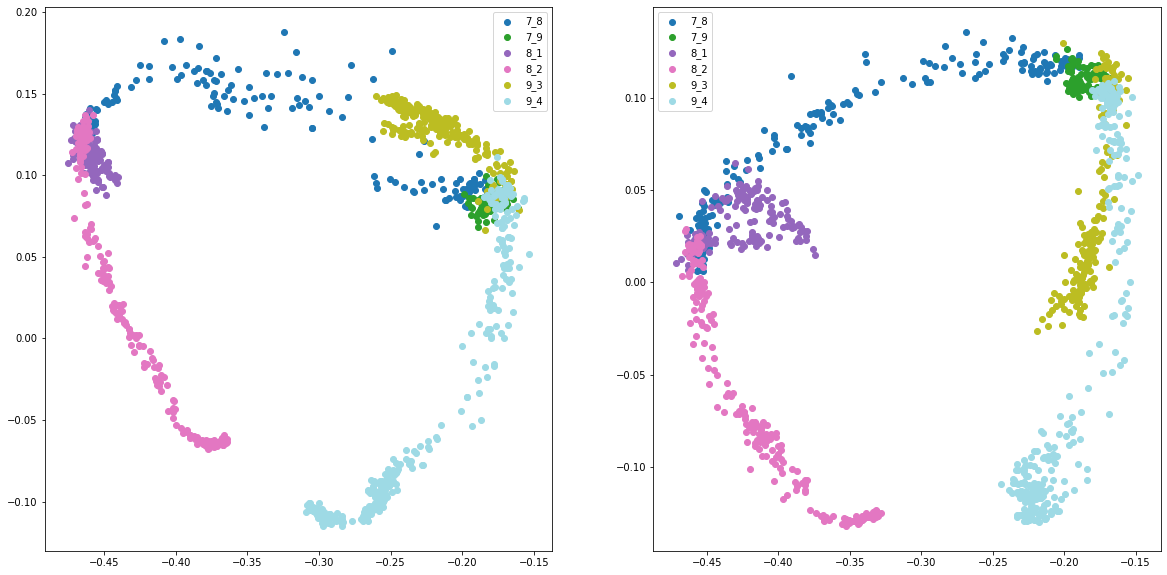

In [25]:
with torch.no_grad():
    for data in test_rna_loader:
        ae_coordinates1 = fusion(encoder1(data['count'].to(device))).cpu().detach().numpy()

    for data in test_atac_loader:
        ae_coordinates2 = fusion(encoder2(data['count'].to(device))).cpu().detach().numpy()

    plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "separate",save = None)

In [35]:
utils.pre_train_disc(encoder1 = encoder1, encoder2 = encoder2, disc = disc, data_loader1 = train_rna_loader, data_loader2 = train_atac_loader, disc_opt = optimizer_D, n_epochs = 201, use_anchor = False)

epoch:  0 Discriminator loss: 0.70358
epoch:  10 Discriminator loss: 0.67784
epoch:  20 Discriminator loss: 0.65628
epoch:  30 Discriminator loss: 0.63048
epoch:  40 Discriminator loss: 0.60164
epoch:  50 Discriminator loss: 0.56743
epoch:  60 Discriminator loss: 0.52669
epoch:  70 Discriminator loss: 0.47770
epoch:  80 Discriminator loss: 0.43065
epoch:  90 Discriminator loss: 0.37999
epoch:  100 Discriminator loss: 0.34408
epoch:  110 Discriminator loss: 0.29881
epoch:  120 Discriminator loss: 0.25299
epoch:  130 Discriminator loss: 0.21832
epoch:  140 Discriminator loss: 0.18936
epoch:  150 Discriminator loss: 0.16062
epoch:  160 Discriminator loss: 0.14044
epoch:  170 Discriminator loss: 0.12050
epoch:  180 Discriminator loss: 0.10744
epoch:  190 Discriminator loss: 0.09382
epoch:  200 Discriminator loss: 0.08479


In [40]:
# n_iter = 200 merge too good
utils.train_unpaired(encoder1 = encoder1, encoder2 = encoder2, decoder1 = decoder1, decoder2 = decoder2, fusion = fusion, disc = disc, data_loader1 = train_rna_loader, data_loader2 = train_atac_loader, diff_sim1 = Diff1, diff_sim2 = Diff2, recon_opt1 = optimizer_rna, recon_opt2 = optimizer_atac, dist_opt1 = optimizer_dist_rna, dist_opt2 = optimizer_dist_atac, disc_opt = optimizer_D, n_epochs=201, n_iter=200, n_iter2 = 1, lamb_r1 = 1, lamb_r2 = 1, lamb_disc=1, dist_mode = "mse", use_anchor = False)

epoch:  0 RNA recon loss: 0.49439, RNA dist loss: 0.13266 ATAC recon loss: 0.01516, ATAC dist loss: 0.14597 Discriminator loss: 0.06734
epoch:  10 RNA recon loss: 0.46490, RNA dist loss: 0.12420 ATAC recon loss: 0.01730, ATAC dist loss: 0.14727 Discriminator loss: 0.07647
epoch:  20 RNA recon loss: 0.42780, RNA dist loss: 0.11845 ATAC recon loss: 0.01475, ATAC dist loss: 0.14174 Discriminator loss: 0.19882
epoch:  30 RNA recon loss: 0.39870, RNA dist loss: 0.12641 ATAC recon loss: 0.01261, ATAC dist loss: 0.14488 Discriminator loss: 0.21440
epoch:  40 RNA recon loss: 0.38096, RNA dist loss: 0.11313 ATAC recon loss: 0.01223, ATAC dist loss: 0.14292 Discriminator loss: 0.20784
epoch:  50 RNA recon loss: 0.34945, RNA dist loss: 0.11832 ATAC recon loss: 0.01298, ATAC dist loss: 0.13682 Discriminator loss: 0.24929
epoch:  60 RNA recon loss: 0.33417, RNA dist loss: 0.11884 ATAC recon loss: 0.01474, ATAC dist loss: 0.15235 Discriminator loss: 0.19558
epoch:  70 RNA recon loss: 0.30985, RNA di

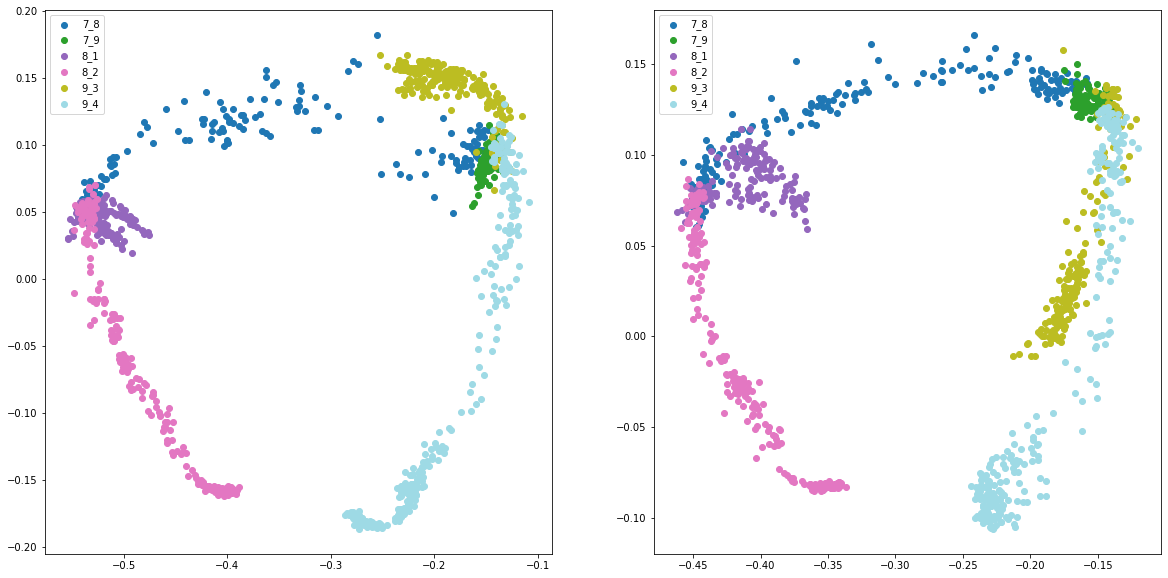

In [42]:
with torch.no_grad():
    for data in test_rna_loader:
        ae_coordinates1 = fusion(encoder1(data['count'].to(device))).cpu().detach().numpy()

    for data in test_atac_loader:
        ae_coordinates2 = fusion(encoder2(data['count'].to(device))).cpu().detach().numpy()

    plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "separate",save = None)

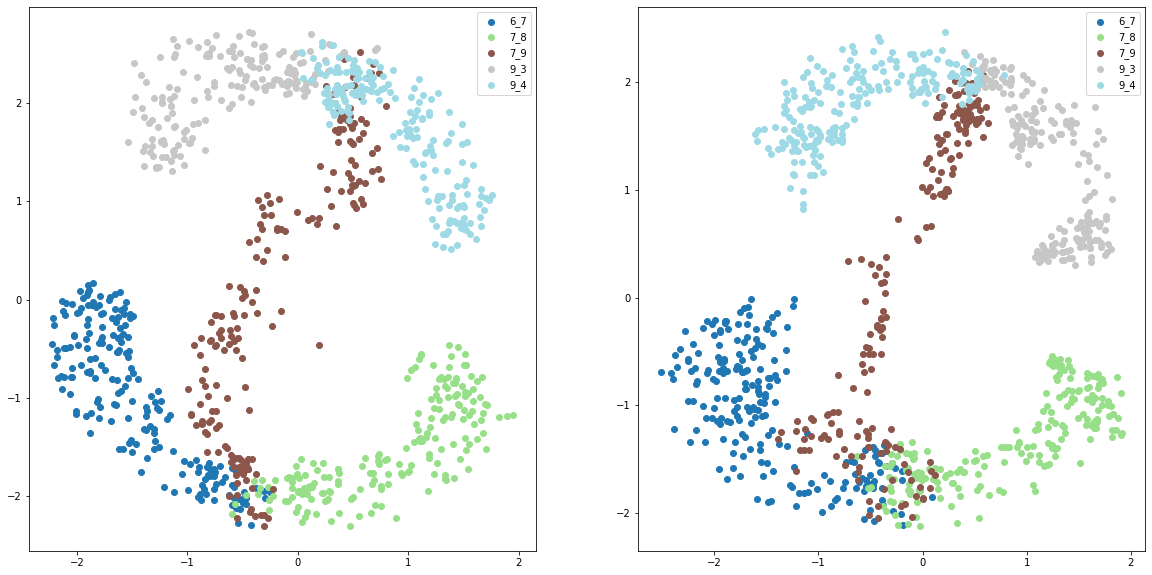

In [12]:
plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "joint",save = None)

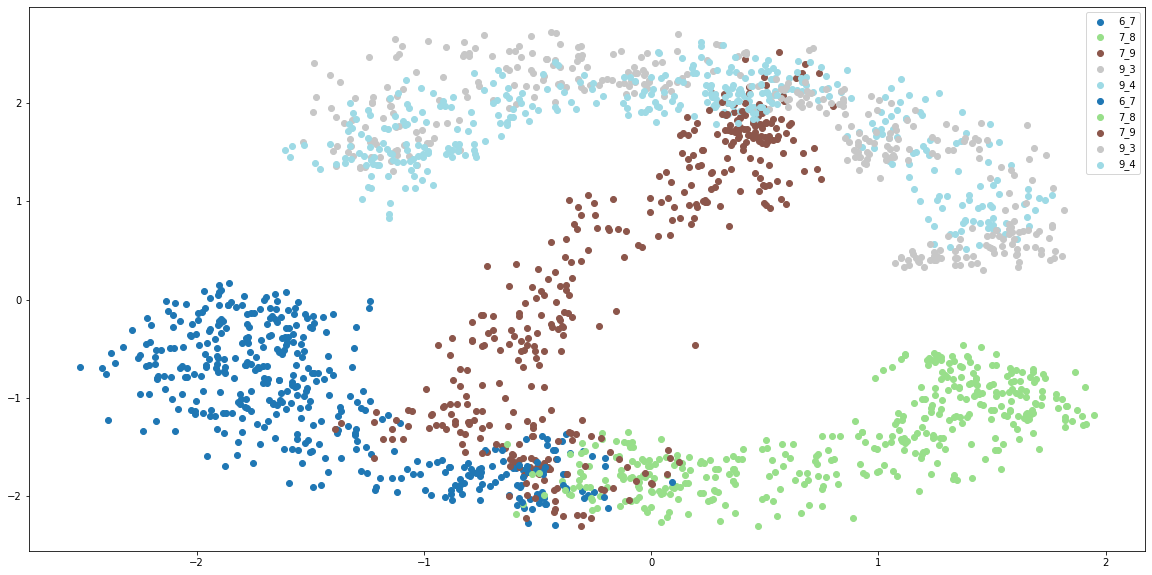

In [13]:
plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "modality",save = None)

In [ ]:
# torch.save({
#     'encoder1': encoder1.state_dict(),
#     'encoder2': encoder2.state_dict(),
#     'disc': disc.state_dict(),
#     'fusion': fusion.state_dict(),
#     'decoder1': decoder1.state_dict(),
#     'decoder2': decoder2.state_dict(),
#     'config1': rna_CONFIG,
#     'config2': atac_CONFIG,
#     'Diff1': Diff1,
#     'Diff2': Diff2
# }, './saved_model/symsim2.pt')

In [ ]:
# state = torch.load('./saved_model/symsim2.pt')

# encoder1 = ae.Encoder(rna_CONFIG).to(device)
# encoder1.load_state_dict(state['encoder1'])

# encoder2 = ae.Encoder(atac_CONFIG).to(device)
# encoder2.load_state_dict(state['encoder2'])

# fusion = ae.Fusion(in_channels = rna_CONFIG['layers'][-1], hidden_channels = 2, embed_channels = 2, activation = False, use_hidden = False)
# fusion.load_state_dict(state['fusion'])

# decoder1 = ae.Decoder(rna_CONFIG).to(device)
# decoder1.load_state_dict(state['decoder1'])

# decoder2 = ae.Decoder(atac_CONFIG).to(device)
# decoder2.load_state_dict(state['decoder2'])

# disc = ae.discriminator(infeatures = rna_CONFIG['layers'][-1], hidden1 = 64, hidden2 = 32, hidden3 = 1).to(device)
# disc.load_state_dict(state['disc'])